In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import random

from pathlib import Path

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch

import datasets
# Don't show progress datasets bars
datasets.disable_progress_bar()

import sys
sys.path.insert(0, str(Path.cwd().parent.resolve()))
from dataset import get_dataset, collator
from reward_model import get_template, get_reward_model, create_reward_fn
from model import get_model
from utils import get_tokenizer

In [3]:
device = torch.device(
    # f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
    "cuda:4"
)
device

device(type='cuda', index=4)

In [4]:
tokenizer_name = "lmsys/vicuna-7b-v1.3"

dataset_name = "AugustasM/burns-datasets-VINC-imdb-ppo-training-v2"

# 11B unsupervised VINC
# reward_model_output_path = "/fsx/home-augustas/logs_elk/UQA-varied-imdb_20230731_174049_49091"

# 11B unsupervised CCS
reward_model_output_path = "/fsx/home-augustas/logs_elk/UQA-11B-v2-custom-imdb-ccs_20230809_140421_56710"

In [5]:
# Tokenizer
tokenizer = get_tokenizer(tokenizer_name)

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading tokenizer lmsys/vicuna-7b-v1.3...


Loaded tokenizer.



## Dataset

In [6]:
# Dataset for PPO training
dataset, _, _ = get_dataset(dataset_name, tokenizer=tokenizer)
print(dataset)

Loading dataset...



Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-b001604fcfe1e0f7_*_of_00012.arrow



Max prompt length: 721



Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-b3d77c60294a5fe0_*_of_00012.arrow
Loading cached shuffled indices for dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-4bbc36bdf5f672c0.arrow


Max response length: 3

Remaining columns: ['prompt', 'best_response', 'input_ids', 'attention_mask', 'response_len']

Total number of examples: 8192

Processing finished.

Dataset({
    features: ['prompt', 'best_response', 'input_ids', 'attention_mask', 'response_len'],
    num_rows: 8192
})


In [7]:
# Dataset templates
dataset_template_path = "AugustasM/burns-datasets-VINC"
template = get_template(dataset_template_path)

Num templates: 1
Is the given text truthful


In [8]:
# Get the reward model
reward_model, reward_model_name = get_reward_model(
    reward_model_output_path, device,
    # supervised=True,
    supervised=False,
)
reward_model_tokenizer = get_tokenizer(reward_model_name)

The current device is cuda:4.

Loading reward model from allenai/unifiedqa-v2-t5-11b-1363200.
is_bf16_possible=True


Loaded reward model with 11,307,321,344 parameters.
Number of trainable params 0 parameters.
Reward model dtype: torch.bfloat16

layer=21
Loading the probe from /fsx/home-augustas/VINC-logs/allenai/unifiedqa-v2-t5-11b-1363200/AugustasM/burns-datasets-VINC-imdb-v2/hardcore-jepsen/reporters/layer_21.pt


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Finished loading the probe.

Loading tokenizer allenai/unifiedqa-v2-t5-11b-1363200...
Falling back to slow tokenizer; fast one failed: 'No such file or directory (os error 2)'
Loaded tokenizer.



In [9]:
rm_batch_size = 4

# Create reward function
get_rewards = create_reward_fn(
    reward_model=reward_model,
    reward_model_tokenizer=reward_model_tokenizer,
    rm_batch_size=rm_batch_size,
    template=template,
    device=device,
)

In [10]:
set(dataset["best_response"])

{'0', '1', 'bad', 'good', 'negative', 'positive'}

In [11]:
opposite_response_dict = {
    "0": "1",
    "1": "0",
    "bad": "good",
    "good": "bad",
    "positive": "negative",
    "negative": "positive",
}

In [12]:
training_dataset = dataset.select(range(2048))
training_dataset

Dataset({
    features: ['prompt', 'best_response', 'input_ids', 'attention_mask', 'response_len'],
    num_rows: 2048
})

In [13]:
golden_responses = training_dataset["best_response"]
golden_responses[:10]

['1', '0', '1', '0', '1', 'good', '1', '0', 'good', 'negative']

In [14]:
random.seed(42)

responses = training_dataset["best_response"]

flip_mask = random.choices([True, False], k=len(responses))
print(sum(flip_mask))

responses = [
    opposite_response_dict[x] if flip_mask[i] else x for i, x in enumerate(responses)
]
responses[:10]

989


['1', '1', '0', '1', '1', 'good', '1', '1', 'bad', 'positive']

In [15]:
sum(g != o for g, o in zip(golden_responses, responses))

989

In [16]:
dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=16, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = [q + r for q, r in zip(batch["prompt"], responses)]

    current_rewards = get_rewards(texts)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Dataloader length: 128


  0%|          | 0/128 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


torch.Size([2048])

## Plots

In [17]:
POSSIBLE_ANSWERS = list(opposite_response_dict.keys()) + list(opposite_response_dict.values())

def is_desired_answer(answer):
    return answer in POSSIBLE_ANSWERS

tensor(1.)


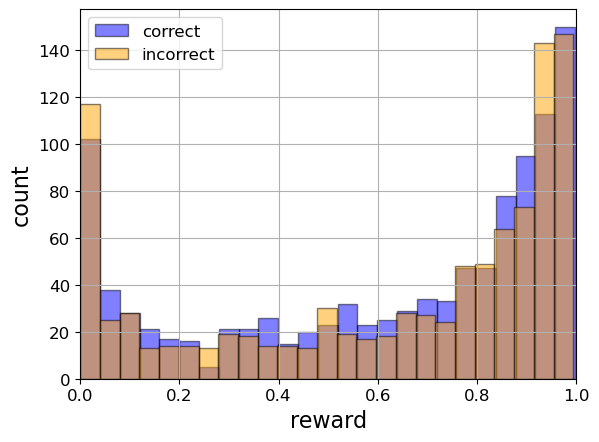

In [19]:
label_fontsize = 16
tick_fontsize = 12

correct_mask = [is_desired_answer(o) and g == o for g, o in zip(golden_responses, responses)]
correct_mask = torch.tensor(correct_mask, dtype=torch.bool)

incorrect_mask = [is_desired_answer(o) and g != o for g, o in zip(golden_responses, responses)]
incorrect_mask = torch.tensor(incorrect_mask, dtype=torch.bool)

print((correct_mask.sum() + incorrect_mask.sum()) / len(correct_mask))

bins=25; color="blue"; secondary_color="orange"; alpha=0.5; xlim=[0, 1]

# median = rewards.median()
# mean = rewards.mean()
# std = rewards.std()

# Histogram of rewards with black borders
plt.hist(
    rewards[correct_mask], bins=bins,
    edgecolor="black", color=color, alpha=alpha,
    label="correct",
)
plt.hist(
    rewards[incorrect_mask], bins=bins, 
    edgecolor="black", color=secondary_color, alpha=alpha,
    label="incorrect",
)

# Set xlim to 0-1
plt.xlim(xlim)

plt.xlabel('reward', fontsize=label_fontsize)
plt.ylabel('count', fontsize=label_fontsize)

# Set the tick label font size
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Grid
plt.grid()

# Legend
plt.legend(fontsize=tick_fontsize)

# plt.savefig("outputs/reward_distribution_CCS.png", dpi=300)